In [1]:
import gym
import gym_mnist
import tensorflow as tf
import logging
from model import EnvModel
from modellearner import ModelLearner
from utils.dataset import iterbatches
import configs
import numpy as np
from utils.latent_visualizer import LatentVisualizer
from utils.getch import getch
from sklearn.cluster import KMeans
from sklearn.metrics import log_loss, normalized_mutual_info_score as nmi_score
import cv2
import os
import matplotlib.pyplot as plt
%matplotlib inline

logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

logdir_base = 'data/testlogdir/flipgame-v0/'
import re
remove_wfeat_regex = re.compile('_wfeat')
remove_wfeat = lambda s: remove_wfeat_regex.sub('', s)
logdir_dict = {remove_wfeat(suffix) : os.path.join(logdir_base, suffix) for suffix in os.listdir(logdir_base)}
#logdir_dict['wfeatures'] = 'data/experiments/linear_wfeat_wgb/'

clustering_score_dict = {}
goal_score_dict = {}
feature_score_dict = {}
replay_memories = False
num_evaluation_batches = 5
max_val_steps = 20
basename = 'feature_varying'

In [2]:
env = gym.make('rotgame-v0')
config = configs.load_config(list(logdir_dict.values())[0])
tf.reset_default_graph()
ml = ModelLearner(env, config)
ml.gather_gameplay_data(num_games=10)
transition_datasets = [ml.create_transition_sequence_dataset(max_steps=i, variable_steps=False) for i in range(1, max_val_steps+1)]
#uncomment lines to cause all episodes to start at 5
#inds = [i for i in range(transition_dataset[0].shape[0]) if transition_dataset[-1][i, 0] == 5]
#transition_dataset = [arr[inds] for arr in transition_dataset]
logger.info("Gameplay data gathered.")

[2017-08-07 14:46:11,808] Making new env: rotgame-v0
[2017-08-07 14:46:23,382] Gameplay data gathered.


In [3]:
logdir_dict

{'run': 'data/testlogdir/flipgame-v0/run',
 'run--00': 'data/testlogdir/flipgame-v0/run--00'}

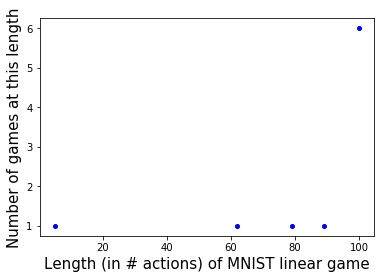

In [4]:
lengths = {}
for game in ml.replay_memory:
    if len(game) in lengths.keys():
        lengths[len(game)] += 1
    else:
        lengths[len(game)] = 1

plt.plot(list(lengths.keys()), list(lengths.values()),'bo', markersize=4)
plt.xlabel('Length (in # actions) of MNIST linear game', size=15)
plt.ylabel('Number of games at this length', size=15)
plt.savefig(os.path.join("figures/",basename + 'gamelengths.svg'))
plt.savefig(os.path.join("figures/",basename + 'gamelengths.png'))

In [5]:
for logname, logdir in logdir_dict.items():
    config = configs.load_config(logdir)
    tf.reset_default_graph()
    ml = ModelLearner(env, config)
    envmodel = ml.envmodel
    from utils.latest_checkpoint_unsafe import latest_checkpoint
    restore_path = latest_checkpoint(logdir)
    var_dict = {var.name[:-2]: var for var in tf.global_variables()}
    restoring_saver = tf.train.Saver(var_list=var_dict)

    with tf.Session() as sess:
        if restore_path is not None:
            logger.info("Restoring variables from checkpoint: {}".format(restore_path))
            restoring_saver.restore(sess, restore_path)
        else:
            logger.info("Initializing brand new network parameters.")
            sess.run(tf.global_variables_initializer())

        feature_scores = []
        goal_scores = []
        for stepind in range(1, max_val_steps+1):
            transition_dataset = transition_datasets[stepind - 1]
            iterb = iterbatches(transition_dataset, batch_size=envmodel.test_batchsize)
            latent_size = config['latent_size']
            feature_shape = config['feature_shape']

            states_full = np.zeros([0] + list(transition_dataset[0].shape[1:]))
            latents_full = np.zeros([0, stepind + 1, latent_size])
            labels_full = np.zeros([0, stepind + 1, 1])
            truegv_full = np.zeros([0, stepind])
            goalvalues_full = np.zeros([0, stepind])
            trueft_full = np.zeros([0, stepind+1] + feature_shape[:-1])
            features_full = np.zeros([0, stepind+1] + feature_shape)
            for _ in range(num_evaluation_batches):
                batch = next(iterb)
                states, actions, truefts, truegoalvalues, goalstates, _, truelabels = batch
                initial_states = states[:, 0]
                initial_latents = envmodel.encode(initial_states)
                _, future_latents = envmodel.stepforward(latent_state=initial_latents, actions=actions)
                initial_latents = np.expand_dims(initial_latents, axis=1)
                latents = np.concatenate([initial_latents, future_latents], axis=1)
                
                b = envmodel.test_batchsize
                
                goallatents = envmodel.encode(goalstates)
                goallatents_flattened = np.tile(np.expand_dims(goallatents, axis=1),
                                               [1, stepind, 1]).reshape([-1, latent_size])
                flattened_future_latents = future_latents.reshape([-1, latent_size])                
                n_values = flattened_future_latents.shape[0]
                goalvalues = []
                for i in range(n_values//b + 1):
                    lower = i*b
                    upper = min((i+1)*b, n_values)
                    latents_chunk = flattened_future_latents[lower:upper]
                    goalstates_chunk = goallatents_flattened[lower:upper]
                    goalvalues_chunk = envmodel.checkgoal(latents_chunk, goalstates_chunk)
                    goalvalues.append(goalvalues_chunk)
                goalvalues = np.concatenate(goalvalues, axis=0).reshape([b, stepind])
                
                flattened_latents = latents.reshape([-1, latent_size])
                n_values = flattened_latents.shape[0]
                
                features = []
                for i in range(n_values//b + 1):
                    lower = i*b
                    upper = min((i+1)*b, n_values)
                    latents_chunk = flattened_latents[lower:upper]
                    features_chunk = envmodel.getfeatures(latents_chunk)
                    features.append(features_chunk)
                features = np.concatenate(features, axis=0).reshape([b, stepind+1] + feature_shape)
                
                
                states_full = np.concatenate([states_full, states], axis=0)
                latents_full = np.concatenate([latents_full, latents], axis=0)
                labels_full = np.concatenate([labels_full, truelabels], axis=0)
                truegv_full = np.concatenate([truegv_full, truegoalvalues], axis=0)
                goalvalues_full = np.concatenate([goalvalues_full, goalvalues], axis=0)
                trueft_full = np.concatenate([trueft_full, truefts], axis=0)
                features_full = np.concatenate([features_full, features], axis=0)
                
            true_goalvalues = truegv_full[:, -1].astype(bool)
            goalvalues = goalvalues_full[:, -1]
            goal_score = log_loss(true_goalvalues, goalvalues, labels=[0, 1])
            
            print("Goal score: {}".format(goal_score))
            goal_scores.append(goal_score)
    
    # At this last timestep, the value remaining in all the "full" containers is for the full length, i.e. max_val_steps
    labels_full = np.squeeze(labels_full, axis=-1)
    kmeans_algorithm = KMeans(n_clusters=10, n_init=100)

    feature_scores = []
    clustering_scores = []
    for i in range(max_val_steps + 1):
        # Cluster-label scores
        labels = labels_full[:, i]
        latents = latents_full[:, i]
        guessed_labels = kmeans_algorithm.fit_predict(latents)
        clustering_score = nmi_score(labels, guessed_labels)
        clustering_scores.append(clustering_score)
        
        # Feature score
        n_classes = feature_shape[-1]
        features = features_full[:, i].reshape(-1, n_classes)
        truefts = trueft_full[:, i].reshape(-1)
        feature_loss = log_loss(truefts, features, labels=list(range(n_classes)))
        feature_scores.append(feature_loss)
        
        print("Step {}: V score - {}, feature loss - {}".format(i, clustering_score, feature_loss))
    clustering_scores = np.asarray(clustering_scores)
    goal_scores = np.asarray(goal_scores)
    feature_scores = np.asarray(feature_scores)
    clustering_score_dict[logname] = clustering_scores
    goal_score_dict[logname] = goal_scores
    feature_score_dict[logname] = feature_scores

[2017-08-07 14:46:36,922] Restoring variables from checkpoint: data/testlogdir/flipgame-v0/run--00/model.ckpt-10000


INFO:tensorflow:Restoring parameters from data/testlogdir/flipgame-v0/run--00/model.ckpt-10000


[2017-08-07 14:46:36,923] Restoring parameters from data/testlogdir/flipgame-v0/run--00/model.ckpt-10000


Goal score: 0.03862957843079558
Goal score: 0.037403644942070664
Goal score: 0.036176916086011424
Goal score: 0.006053085131947092
Goal score: 0.03686302171578817
Goal score: 0.0065307650698034955
Goal score: 0.00672646324798853
Goal score: 0.03785210733945803
Goal score: 0.007322750686503063
Goal score: 0.007470900459633759
Goal score: 0.06714385084753502
Goal score: 0.03786903691964649
Goal score: 0.06688294115649204
Goal score: 0.03930713839305736
Goal score: 0.03752266172373726
Goal score: 0.03880676240362703
Goal score: 0.06932350035699282
Goal score: 0.008572072115484223
Goal score: 0.008960552943980104
Goal score: 0.06940261414407262
Step 0: V score - 0.2460978424216835, feature loss - 0.06500938727891184
Step 1: V score - 0.1848174532633787, feature loss - 0.9176021844452066
Step 2: V score - 0.12339142080777157, feature loss - 1.191067684962764
Step 3: V score - 0.08789678773947895, feature loss - 1.2463146705411887
Step 4: V score - 0.12944775546892634, feature loss - 1.27607

AttributeError: 'NoneType' object has no attribute 'model_checkpoint_path'

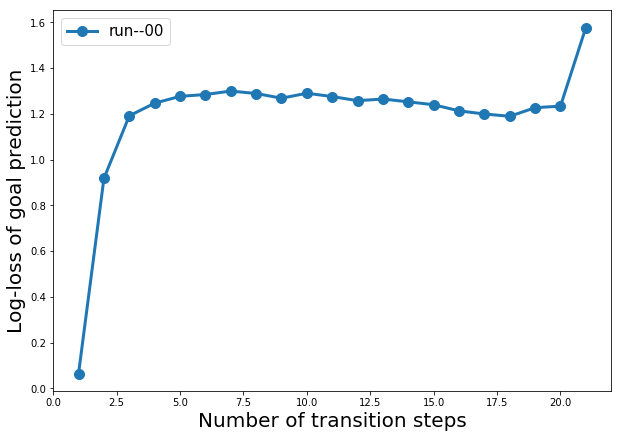

In [8]:
plt.figure(figsize=(10,7))
pairs = ((n, g) for n, g in feature_score_dict.items() if n != 'wfeatures')
for name, goalscore in pairs:
    plt.plot(np.arange(1, max_val_steps +2), goalscore, label=name, linewidth=3, linestyle='-', marker='o', markersize=10)
    plt.legend(fontsize=15)
    plt.xlabel("Number of transition steps", size=20)
    plt.ylabel("Log-loss of goal prediction", size=20)
plt.savefig(os.path.join("figures",basename + 'rewpred.svg'))
plt.savefig(os.path.join("figures",basename + 'rewpred.png'))

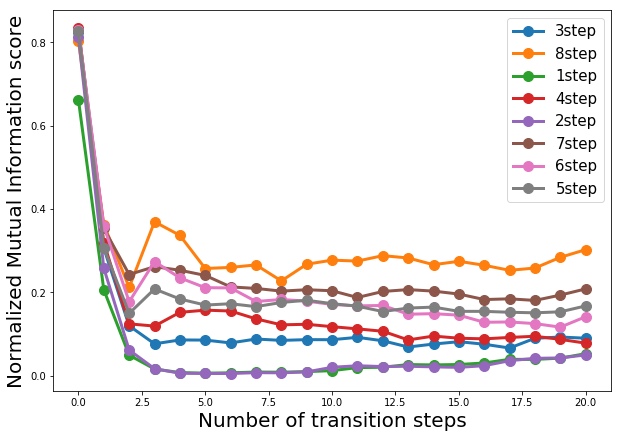

In [19]:
plt.figure(figsize=(10,7))
pairs = ((n, g) for n, g in clustering_score_dict.items() if n[-5:] != 'wfeatures')
for name, vscore in pairs:
    plt.plot(np.arange(max_val_steps + 1), vscore, label=name, linewidth=3, linestyle='-', marker='o', markersize=10)
    plt.legend(fontsize=15)
    # NOTES TO ADD: THIS IS WITH PREDICTION ALWAYS STARTING AT 5, AND REFLECTS THE FACT THAT AS X DECREASES, ACCURACY DROPS
    # BUT CHART WITHOUT ALWAYS STARTING AT 5 SHOWS OPPOSITE! BECAUSE IT'S DOING WELL CLOSE TO EDGES
    plt.xlabel("Number of transition steps", size=20)
    plt.ylabel("Normalized Mutual Information score", size=20)
plt.savefig(os.path.join("figures",basename + 'smi.svg'))
plt.savefig(os.path.join("figures",basename + 'smi.png'))

In [71]:
[n for n in clustering_score_dict.keys()]

['5step',
 '3step_nogb',
 '4step',
 '4step_nogb',
 'wfeatures',
 '2step',
 '1step',
 '6step',
 '2step_nogb',
 '6step_nogb',
 '3step',
 '5step_nogb',
 '1step_nogb']

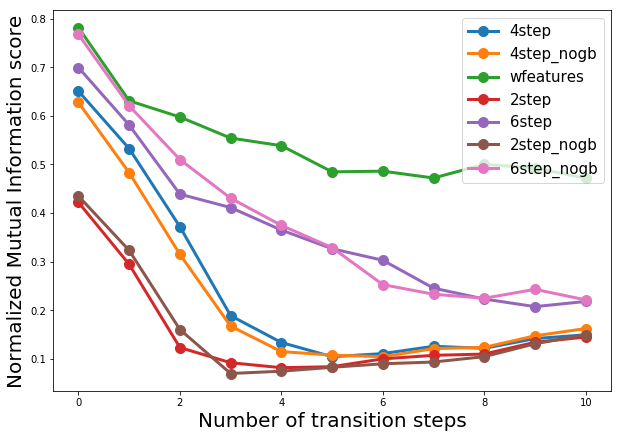

In [78]:
plt.figure(figsize=(10,7))
pairs = ((n, g) for n, g in clustering_score_dict.items() if n[0] not in '135')
for name, vscore in pairs:
    plt.plot(np.arange(max_val_steps + 1), vscore, label=name, linewidth=3, linestyle='-', marker='o', markersize=10)
    plt.legend(fontsize=15)
    # NOTES TO ADD: THIS IS WITH PREDICTION ALWAYS STARTING AT 5, AND REFLECTS THE FACT THAT AS X DECREASES, ACCURACY DROPS
    # BUT CHART WITHOUT ALWAYS STARTING AT 5 SHOWS OPPOSITE! BECAUSE IT'S DOING WELL CLOSE TO EDGES
    plt.xlabel("Number of transition steps", size=20)
    plt.ylabel("Normalized Mutual Information score", size=20)
plt.savefig('figures/smi_gbvarying.svg')
plt.savefig('figures/smi_gbvarying.png')